## A Problem that stumped Milton Friedman

(and that Abraham Wald solved by inventing sequential analysis)

**Authors**: Chase Coleman and Thomas J. Sargent, translated from Python by Alberto Polo

**Abstract**:

This notebook is a condensed version of the QuantEcon lecture [A Problem that Stumped Milton Friedman](https://lectures.quantecon.org/py/wald_friedman.html) which began with the corresponding [notebook](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/Wald_Friedman.ipynb) from the [QuantEcon.Notebooks website](https://quantecon.org/notebooks.html). It introduces the problem that motivated the invention of sequential analysis which was developed by Abraham Wald during WWII. Rather than solve the problem via sequential analysis, we will set it up as a dynamic programming problem.

In [ ]:
using Distributions
using PyPlot
using QuantEcon.compute_fixed_point, QuantEcon.DiscreteRV,
      QuantEcon.draw, QuantEcon.LinInterp

## Introduction

On pages 137-139 of **Two Lucky People** by Milton and Rose Friedman, they describe a problem presented to Milton Friedman and Allen Wallis during World War II when they worked at the U.S. government's Statistical Research Group at Columbia University.  

> In order to understand the story, it is necessary to have an idea of a simple statistical problem, and of the standard procedure for dealing with it.  The actual problem out of which sequential analysis grew will serve. The Navy has two alternative designs (say A and B) for a projectile.  It wants to determine which is superior. To do so it undertakes a series of paired firings. On each round it assigns the value 1 or 0 to A accordingly as its performance is superior or inferio to that of B and conversely 0 or 1 to B.  The Navy asks the statistician how to conduct the test and how to analyze the results. 
   
> The standard statistical answer was to specify a number of firings (say 1,000) and a pair of percentages (e.g., 53% and 47%) and tell the client that if A receives a 1 in more than 53% of the firings, it can be regarded as superior; if it receives a 1 in fewer than 47%, B can be regarded as superior; if the percentage is between 47% and 53%, neither can be so regarded.
   
> When Allen Wallis was discussing such a problem with (Navy) Captain Garret L. Schyler, the captain objected that such a test, to quote from Allen's account, may prove wasteful.  If a wise and seasoned ordnance officer like   Schyler were on the premises, he would see after the first few thousand or even few hundred [rounds] that the experiment need not be completed either because he new method is obviously inferior or because it is obviously superior beyond what was hoped for..."
  
Friedman and Wallis struggled with the problem but after realizing that they were not able to solve it themselves told Abraham Wald it. That started Wald on the path that led  *Sequential Analysis*. We will instead formulate the problem using dynamic programming.

## Dynamic programming formulation


The following presentation of the problem closely follows Dmitri Berskekas's treatment in **Dynamic Programming and Stochastic Control**.

An i.i.d. random variable $z$ can take on values $z \in [v_1, v_2, \dots, v_n]$

A decision maker wants to  know which of two probability distributions governs  $z$. To formalize this idea,
let $x \in [x_0, x_1]$ be a hidden state that indexes the two distributions:

$$P(v_k \mid x) = \begin{cases} f_0(v_k) & \mbox{if } x = x_0, \\
                                f_1(v_k) & \mbox{if } x = x_1. \end{cases}$$                            

Before observing any outcomes, a decision maker believes that the probability that $x = x_0$ is $p_{-1} \in (0,1)$: 

$$ p_{-1} = \textrm{Prob}(x=x_0 \mid \textrm{ no observations}) $$

After observing $k+1$ observations $z_k, z_{k-1}, \ldots, z_0$ he believes that the probability that the distribution is $f_0$ is

$$p_k = \textrm{Prob} (x=x_0 \mid z_k, z_{k-1}, \ldots, z_0) $$

We can compute this $p_k$ recursively by applying Bayes' law:

$$p_k = \frac{ p_{k-1} f_0(z_k)}{ p_{k-1} f_0(z_k) + (1-p_{k-1}) f_1(z_k) } $$

After observing $z_k, z_{k-1}, \dots, z_0$, the decision maker believes that $z_{k+1}$ 
has probability distribution, $f$, given by

$$f(z_{k+1}) = p_k f_0(z_{k+1}) + (1-p_k) f_1 (z_{k+1}). $$

This is evidently a mixture of distributions $f_0$ and $f_1$, with the weight on $f_0$ being the posterior probability $f_0$ that the distribution is $f_0$. 

**Remark:** *Because the decision maker believes that $z_{k+1}$ is drawn from a mixture of two i.i.d. distributions, he does *not* believe that the sequence  $[z_{k+1}, z_{k+2}, \ldots] $ is i.i.d.  Instead, he believes that it is *exchangeable*.  See David Kreps
*Notes on the Theory of Choice*, chapter 11, for a discussion.*

### Example Mixture Distributions

Let's look at some examples of two distributions. Here we'll display two beta distributions.  First, we'll show the two distributions, then we'll show mixtures of these same two distributions with various mixing probabilities $p_k$.

In [2]:
# Create two distributions over 50 values for k
# We are using a discretized beta distribution
function discretize_beta(a, b; p_m1=linspace(0, 1, 50))
    f = clamp.(pdf(Beta(a, b), p_m1), 1e-8, Inf)
    f = f / sum(f)

    return f
end
    
p_m1 = linspace(0, 1, 50)
f0 = discretize_beta(1, 1)
f1 = discretize_beta(9, 9);
f1 = clamp.(pdf(Beta(9, 9), p_m1), 1e-8, Inf)
f1 = f1 / sum(f1);

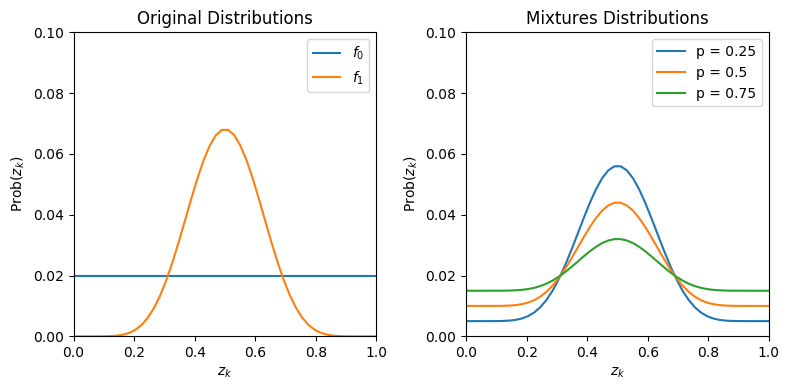

In [3]:
fig, ax = subplots(1, 2, figsize=(8, 4))

ax[1][:plot](p_m1, f0, label="\$f_0\$")
ax[1][:plot](p_m1, f1, label="\$f_1\$")
ax[1][:set_title]("Original Distributions")

for _p in [0.25, 0.5, 0.75]
    ax[2][:plot](p_m1, _p.*f0 + (1.0-_p).*f1, label="p = $_p")
end
ax[2][:set_title]("Mixtures Distributions")

function set_features(cax)
    cax[:set_xlabel]("\$z_k\$")
    cax[:set_ylabel]("Prob\$(z_k)\$")
    cax[:set_xlim](0.0, 1.0)
    cax[:set_ylim](0.0, 0.1)
    cax[:legend]()

    return nothing
end

map(set_features, ax)
fig[:tight_layout]();

### Losses and costs


After observing $z_k, z_{k-1}, \ldots, z_0$, the decision maker chooses among three distinct actions:

* He decides that $x = x_0$ and draws no more $z$'s
* He decides that $x = x_1$ and draws no more $z$'s
* He postpones deciding now and instead chooses to draw a $z_{k+1}$

Associated with these three actions, the decision maker suffers three kinds of losses:

 
* A loss $L_0$ if he decides $x = x_0$ when actually $x=x_1$
* A loss $L_1$ if he decides $x = x_1$ when actually $x=x_0$
* A cost $c$ if he postpones deciding and chooses instead to draw another $z$ 

For example, suppose that we regard $x=x_0$ as a null hypothesis. Then  

* We can think of $L_1$ as the loss associated with a type I error
* We can think of $L_0$ as the loss associated with a type II error

### Test

#### How fast can you figure out the distribution?

In what follows, we are going to take the role of the decision maker. I will give a set of possible distributions of which one distribution will be drawn randomly then we will simulate draws from them and display them one draw at a time.

When you think you know which distribution the draws are coming from, raise your hand.

* Would the time at which you raised your hand change if your life depended on it?
* Would I charged you a quarter for each draw before you raised your hand?

Later, we will allow the model's decision maker to answer these types of questions.

In [4]:
function data_generating_process(ab_pairs; N=250)

    # Randomly decide between the two sets of parameters
    n = length(ab_pairs)
    chosendist = rand(collect(1:n))
    a, b = ab_pairs[chosendist]

    rand_draws = rand(Beta(a, b), N)

    return chosendist, rand_draws
end


data_generating_process (generic function with 1 method)

#### Easy case

We will begin with two easily distinguishable distributions

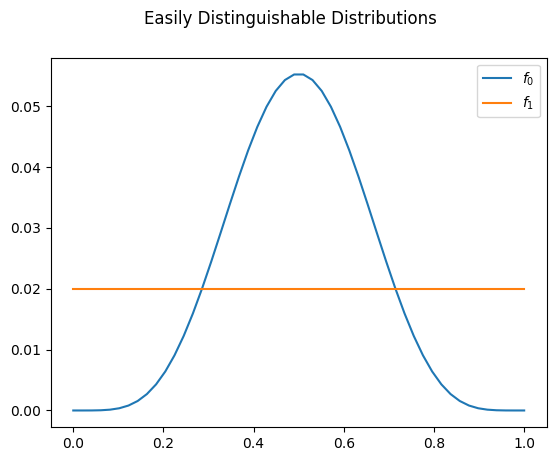

PyObject <matplotlib.text.Text object at 0x7fb9f58426a0>

In [5]:
ab_pairs = [(6.0, 6.0), (1.0, 1.0)]
N = 50

p_m1 = linspace(0, 1, 50)
f0 = discretize_beta(ab_pairs[1][1], ab_pairs[1][2])
f1 = discretize_beta(ab_pairs[2][1], ab_pairs[2][2])

fig, ax = subplots()
ax[:plot](p_m1, f0, label="\$f_0\$")
ax[:plot](p_m1, f1, label="\$f_1\$")
ax[:legend]()
fig[:suptitle]("Easily Distinguishable Distributions")

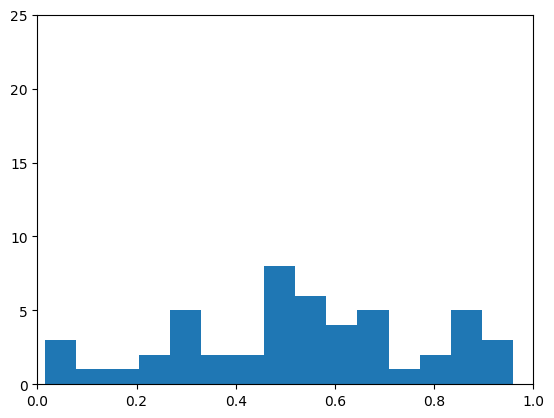

The correct answer was 1


In [6]:
tdgp, data = data_generating_process(ab_pairs; N=N)

fig, ax = subplots()

for n=1:N
    cla()

    ax[:hist](data[1:n], animated=true, normed=false, bins=15)
    ax[:set_xlim](0.0, 1.0)
    ax[:set_ylim](0.0, 25.0)

    sleep(0.05)
    IJulia.clear_output(true)
    display(fig)
end
clf()

println("The correct answer was $(tdgp-1)")

#### Challenging Case

Now, we complicate matters by choosing more similar distributions

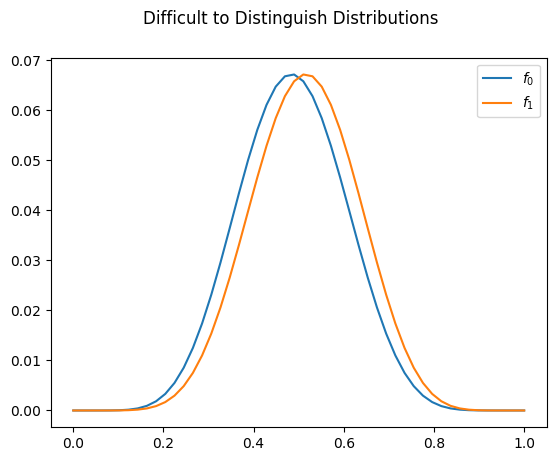

PyObject <matplotlib.text.Text object at 0x7fb9f4e91d30>

In [7]:
ab_pairs = [(8.5, 9.0), (9.0, 8.5)]
N = 125

p_m1 = linspace(0, 1, 50)
f0 = discretize_beta(ab_pairs[1][1], ab_pairs[1][2])
f1 = discretize_beta(ab_pairs[2][1], ab_pairs[2][2])

fig, ax = subplots()
ax[:plot](p_m1, f0, label="\$f_0\$")
ax[:plot](p_m1, f1, label="\$f_1\$")
ax[:legend]()
fig[:suptitle]("Difficult to Distinguish Distributions")

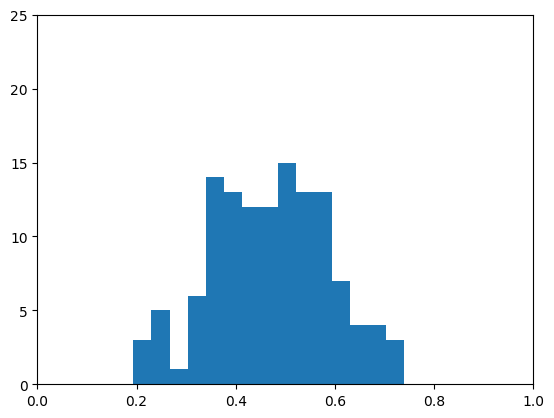

The correct answer was 1


In [8]:
tdgp, data = data_generating_process(ab_pairs; N=N)

fig, ax = subplots()

for n=1:N
    cla()

    ax[:hist](data[1:n], animated=true, normed=false, bins=15)
    ax[:set_xlim](0.0, 1.0)
    ax[:set_ylim](0.0, 25.0)

    IJulia.clear_output(true)
    display(fig)
end
clf()

println("The correct answer was $(tdgp-1)")

### Returning to the math

#### A Bellman equation

Let $J(p_k)$ be the total loss for a decision maker who with posterior probability $p_k$ who chooses optimally.

The loss function $J(p_k)$ satisfies the Bellman equation

$$ J(p_k) = \min \left\{ (1-p_k) L_0, p_k L_1, c + E_{z_{k+1}} \left[ J (p_{k+1}) \right] \right\} $$

where $E_{z_{k+1}}$ denotes a mathematical expectation (using today's beliefs!) over the distribution of $z_{k+1}$ and  the minimization is over the three actions, accept $x_0$, accept $x_1$, and postponing by drawing $z_{k+1}$.

Let 

$$A(p_k) = E_{z_{k+1}} \left[ J \left( \frac{ p_k f_0(z_{k+1})}{ p_k f_0(z_{k+1}) + (1-p_k) f_1 (z_{k+1}) } \right) \right] $$

Then we can write out Bellman equation as

$$ J(p_k) = \min \left[ (1-p_k) L_0, p_k L_1, c + A(p_k) \right] $$

where $p_k \in [0,1]$.  

One can show that the optimal decision rule is characterized by two probabilities $0 < \beta < \alpha < 1$ such that

$$(1- p_k) L_0 < \min \{ p_k L_1, c + A_k(p_k) \}  \textrm { if } p_k \geq \alpha_k  $$

and 

$$ p_k L_1 < \min \{ (1-p_k) L_0,  c + A_k(p_k) \} \textrm { if } p_k \leq \beta_k $$

The optimal decision rule is then

$$ \textrm { accept } x=x_0 \textrm{ if } p_k \geq \alpha_k \\
   \textrm { accept } x=x_1 \textrm{ if } p_k \leq \beta_k \\
   \textrm { draw another }  z \textrm{ if }  \beta_k \leq p_k \leq \alpha_k $$

## Solution to Bellman equation

To approximate the solution of the Bellman equation above, we can deploy a method known as value function iteration. Value function iteration consists of starting with an initial guess of the value function and then evaluating the Bellman equation by using the guess to evaluate the expectation. There is theory that says this should converge to the "true" value function.

Numerically, this will consist of guessing the value of a function over a grid of points and then updating the values on that grid. Because we are iterating on a grid, the current probability, $p_k$, is restricted to a set number of points. However, in order to evaluate the expectation of the Bellman equation for tomorrow, $A(p_{k})$, we must be able to evaluate at various $p_{k+1}$ which may or may not correspond with points on our grid. The way that we resolve this issue is by using *linear interpolation*. This means to evaluate $J(p)$ where $p$ is not a grid point, we must use two points: first, we use the largest of all the grid points smaller than $p$, and call it $p_i$, and, second, we use the grid point immediately after $p$, named $p_{i+1}$, to approximate the function value in the following manner:

$$ J(p) = J(p_i) + (p - p_i) \frac{J(p_{i+1}) - J(p_i)}{p_{i+1} - p_{i}}$$

In one dimension, you can think of this as simply drawing a line between each pair of points on the grid.

For more information on both linear interpolation and value function iteration methods, see the Quant-Econ [lecture](http://quant-econ.net/py/ifp.html) on the income fluctuation problem.

## Julia Implementation

### Define relevant types

In [9]:
"""
This type is used to store the solution to the problem presented 
in the "Wald Friedman" notebook presented on the QuantEcon website.

Solution
----------
J : vector(Float64)
    Discretized value function that solves the Bellman equation
β : scalar(Real)
    Lower cutoff for continuation decision
α : scalar(Real)
    Upper cutoff for continuation decision
"""
mutable struct WFSolution
    J::Vector{Float64}
    β::Float64
    α::Float64
end

"""
This type is used to solve the problem presented in the "Wald Friedman"
notebook presented on the QuantEcon website.

Parameters
----------
c : scalar(Real)
    Cost of postponing decision
L0 : scalar(Real)
    Cost of choosing model 0 when the truth is model 1
L1 : scalar(Real)
    Cost of choosing model 1 when the truth is model 0
f0 : vector(Float64)
    A finite state probability distribution
f1 : vector(Float64)
    A finite state probability distribution
m : scalar(Int64)
    Number of points to use in function approximation
"""
struct WaldFriedman
    c::Float64
    L0::Float64
    L1::Float64
    f0::Vector{Float64}
    f1::Vector{Float64}
    m::Int64
    pgrid::LinSpace{Float64}
    sol::WFSolution
end

function WaldFriedman(c, L0, L1, f0, f1)
    # Make sure distributions have same number
    # of elements
    m = length(f0)
    @assert m == length(f1)

    pgrid = linspace(0.0, 1.0, m)

    # Renormalize distributions so nothing is "too" small
    f0 = clamp.(f0, 1e-8, 1-1e-8)
    f1 = clamp.(f1, 1e-8, 1-1e-8)
    f0 = f0 ./ sum(f0)
    f1 = f1 ./ sum(f1)

    # Guess the value function is 0 everywhere
    J = zeros(m)
    beta = 0.
    alpha = 1.
    
    WaldFriedman(c, L0, L1, f0, f1, m, pgrid, WFSolution(J, beta, alpha))
end

WaldFriedman

### Helper functions

In [10]:
"""
This function takes a value for the probability with which
the correct model is model 0 and returns the mixed
distribution that corresponds with that belief.
"""
function current_distribution(wf::WaldFriedman, p::Float64)

    return p*wf.f0 + (1-p)*wf.f1
end

"""
This function takes a value for p, and a realization of the
random variable and calculates the value for p tomorrow.
"""
function bayes_update(wf::WaldFriedman, p::Float64, k::Int)
    f0_k = wf.f0[k]
    f1_k = wf.f1[k]

    p_tp1 = p*f0_k / (p*f0_k + (1-p)*f1_k)

    return clamp.(p_tp1, 0, 1)
end

"""
This is similar to `bayes_update_k` except it returns a
new value for p for each realization of the random variable
"""
function bayes_update(wf::WaldFriedman, p::Float64)

    return bayes_update.(wf, p, 1:wf.m)
end

"""
For a given probability specify the cost of accepting model 0
"""
function payoff_choose_f0(wf::WaldFriedman, p)

    return (1-p)*wf.L0
end

"""
For a given probability specify the cost of accepting model 1
"""
function payoff_choose_f1(wf::WaldFriedman, p)

    return p*wf.L1
end

"""
This function evaluates the expectation of the value function
at period t+1. It does so by taking the current probability
distribution over outcomes:

    p(z_{k+1}) = p_k f_0(z_{k+1}) + (1-p_k) f_1(z_{k+1})

and evaluating the value function at the possible states
tomorrow J(p_{t+1}) where

    p_{t+1} = p f0 / ( p f0 + (1-p) f1)

Parameters
----------
p : scalar
    The current believed probability that model 0 is the true
    model.
J : function (interpolant)
    The current value function for a decision to continue

Returns
-------
EJ : scalar
    The expected value of the value function tomorrow
"""
function EJ(wf::WaldFriedman, p, J)
    # Get the current believed distribution (to use in taking
    # the expectation)
    curr_dist = current_distribution(wf, p)

    # Evaluate the new belief tomorrow for each possible realization
    tp1_dist = bayes_update(wf, p)
   
    # Dot product of my current beliefs with value function at
    # each p tomorrow gives me expected value
    EJ = dot(curr_dist, J.(tp1_dist))

    return EJ
end

"""
For a given probability distribution and value function give
cost of continuing the search for correct model
"""
function payoff_continue(wf::WaldFriedman, p, J)
    return wf.c + EJ(wf, p, J)
end

"""
This function takes a value function and returns the corresponding
cutoffs of where you transition between continue and choosing a
specific model
"""
function find_cutoff_rule(wf::WaldFriedman, J)
    m, pgrid = wf.m, wf.pgrid

    # Evaluate cost at all points on grid for choosing a model
    p_c_0 = payoff_choose_f0(wf, pgrid)
    p_c_1 = payoff_choose_f1(wf, pgrid)

    # The cutoff points can be found by differencing these costs with
    # the Bellman equation (J is always less than or equal to p_c_i)
    beta = pgrid[searchsortedlast(p_c_1 - J, 1e-10)]
    alpha = pgrid[searchsortedlast(J - p_c_0, -1e-10)]

    return beta, alpha
end

find_cutoff_rule

### Solve

In [11]:
"""
Evaluates the value function for a given continuation value
function; that is, evaluates

    J(p) = min( (1-p)L0, pL1, c + E[J(p')])

Uses linear interpolation between points
"""
function bellman_operator(wf::WaldFriedman, J)
    c, L0, L1, f0, f1 = wf.c, wf.L0, wf.L1, wf.f0, wf.f1
    m, pgrid = wf.m, wf.pgrid

    J_out = zeros(m)
    J_interp = LinInterp(pgrid, J)
    
    for (p_ind, p) in enumerate(pgrid)
        # Payoff of choosing model 0
        p_c_0 = payoff_choose_f0(wf, p)
        p_c_1 = payoff_choose_f1(wf, p)
        p_con = payoff_continue(wf, p, J_interp)

        J_out[p_ind] = min(p_c_0, p_c_1, p_con)
    end

    return J_out
end

function solve_model(wf; tol=1e-7)
    bell_op(x) = bellman_operator(wf, x)
    J =  compute_fixed_point(bell_op, zeros(wf.m), err_tol=tol, print_skip=5)

    wf.sol.J = J
    wf.sol.β, wf.sol.α = find_cutoff_rule(wf, J)
    return J
end

solve_model (generic function with 1 method)

### Exercise: Write a simulation function

There is a template below (the answer is also below)... It should take a model, a true distribution, and a prior that $f_0$ is correct.

In [ ]:
"""
This function takes an initial condition and simulates until it
stops (when a decision is made).
"""
function simulate(wf::WaldFriedman, f; p0=0.5)
    # Check whether vf is computed
    if sum(abs, wf.sol.J) < 1e-8
        solve_model(wf)
    end
        
    # Unpack useful info
    beta, alpha = wf.sol.β, wf.sol.α
    drv = DiscreteRV(f)

    # Initialize a couple useful variables
    decision_made = false
    decision = 0
    p = p0
    t = 0

    # While some condition is true
    while (???)
        # Draw an a new realization
        k = rand(drv)[1]
        t = t+1

        # Update according to Bayes law
        p = bayes_update(wf, p, k)
        # what happens if p is below beta?
        if (???)

        # What happens if p is above alpha
        elseif (???)

        end
    end
            
    return decision, p, t
end

<button data-toggle="collapse" data-target="#sol2" class='btn btn-primary'>One Possible Solution</button>
<div id="sol2" class="collapse">

```julia
"""
This function takes an initial condition and simulates until it
stops (when a decision is made).
"""
function simulate(wf::WaldFriedman, f; p0=0.5)
    # Check whether vf is computed
    if sum(abs, wf.sol.J) < 1e-8
        solve_model(wf)
    end
        
    # Unpack useful info
    beta, alpha = wf.sol.β, wf.sol.α
    drv = DiscreteRV(f)

    # Initialize a couple useful variables
    decision_made = false
    decision = 0
    p = p0
    t = 0

    while !decision_made
        # Draw an a new realization
        k = rand(drv)[1]
        t = t+1

        # Update according to Bayes law
        p = bayes_update(wf, p, k)
        if p < beta
            decision_made = true
            decision = 1
        elseif p > alpha
            decision_made = true
            decision = 0
        end
    end
            
    return decision, p, t
end
```

In [13]:
"""
Uses the distribution f0 as the true data generating
process
"""
function simulate_tdgp_f0(wf::WaldFriedman; p0=0.5)
    decision, p, t = simulate(wf, wf.f0; p0=p0)

    if decision == 0
        correct = true
    else
        correct = false
    end
        
    return correct, p, t
end

"""
Uses the distribution f1 as the true data generating
process
"""
function simulate_tdgp_f1(wf::WaldFriedman; p0=0.5)
    decision, p, t = simulate(wf, wf.f1; p0=p0)

    if decision == 1
        correct = true
    else
        correct = false
    end
        
    return correct, p, t
end

"""
Simulates repeatedly to get distributions of time needed to make a
decision and how often they are correct.
"""
function stopping_dist(wf::WaldFriedman; ndraws=250, tdgp="f0")
    if tdgp=="f0"
        simfunc = simulate_tdgp_f0
    else
        simfunc = simulate_tdgp_f1
    end
        
    # Allocate space
    tdist = Array{Int64}(ndraws)
    cdist = Array{Bool}(ndraws)

    for i in 1:ndraws
        correct, p, t = simfunc(wf)
        tdist[i] = t
        cdist[i] = correct
    end
        
    return cdist, tdist
end

stopping_dist

Now let's use our types to solve the Bellman equation (*) and check whether it gives the same answer attained above.

### Numerical Example

Now let's specify the two probability distibutions (the ones that we plotted earlier)

* for $f_0$ we'll assume a beta distribution with parameters $a=1, b=1$

* for $f_1$ we'll assume a beta distribution with parameters $a=9, b=9$

The density of a  beta probability distribution with parameters $a$ and $b$ is

$$ f(z; a, b) = \frac{\Gamma(a+b) z^{a-1} (1-z)^{b-1}}{\Gamma(a) \Gamma(b)}$$

where $\Gamma$ is the gamma function 

$$\Gamma(t) = \int_{0}^{\infty} x^{t-1} e^{-x} dx$$


In [14]:
# Choose parameters
c = 1.25
L0 = 27.0
L1 = 27.0

# Choose n points and distributions
m = 251
f0 = pdf(Beta(2.5, 3), linspace(0, 1, m))
f0 = f0 / sum(f0)
f1 = pdf(Beta(3, 2.5), linspace(0, 1, m))
f1 = f1 / sum(f1)  # Make sure sums to 1

# Create an instance of our WaldFriedman class
wf = WaldFriedman(c, L0, L1, f0, f1);

solve_model(wf);

Compute iterate 5 with error 1.2384971736003703
Compute iterate 10 with error 0.623568919859812
Compute iterate 15 with error 0.0317816512897835
Compute iterate 20 with error 0.0005980373085616719
Compute iterate 25 with error 1.1172556858340954e-5
Compute iterate 30 with error 2.0872615458245036e-7
Converged in 31 steps


In [15]:
# Solve and simulate the solution
cdist, tdist = stopping_dist(wf; ndraws=5000)

(Bool[false, true, true, true, false, false, true, true, true, false  …  true, false, true, true, true, true, true, false, true, true], [1, 2, 3, 2, 2, 4, 3, 1, 2, 1  …  2, 1, 1, 2, 1, 4, 2, 1, 2, 1])

#### Plotting the value function

The value function equals $ p L_1$ for $p \leq \alpha$, and $(1-p )L_0$ for $ p \geq \beta$.
Thus, the slopes of the two linear pieces of the value function are determined by $L_1$ and 
$- L_0$.  

The value function is smooth in the interior region in which the probability assigned to distribution  $f_0$ is in the indecisive region $p \in (\alpha, \beta)$.

The decision maker continues to sample until the probability that he attaches to model $f_0$ falls below $\alpha$ or above $\beta$.

The value function is smooth in the interior region in which the probability assigned to distribution  $f_0$ is in the indecisive region $p \in (\alpha, \beta)$.



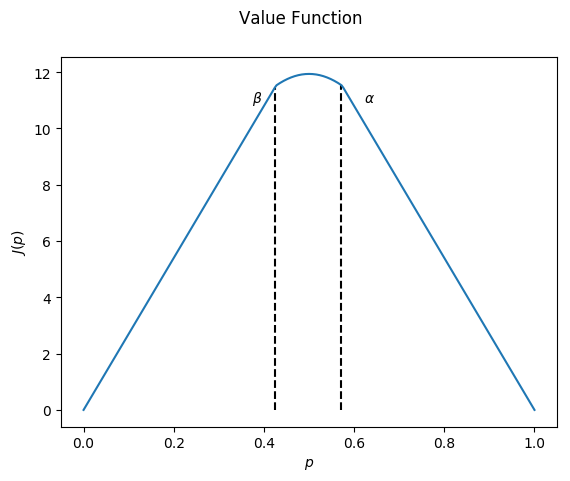

PyObject <matplotlib.text.Text object at 0x7fb9f4fd0eb8>

In [16]:
fig, ax = subplots()

ax[:plot](wf.pgrid, wf.sol.J)

maxJ = maximum(wf.sol.J)
ax[:vlines](wf.sol.β, 0.0, wf.sol.β*wf.L1, "k", "--")
ax[:annotate](L"$\beta$", (wf.sol.β-0.05, maxJ - 1.0))
ax[:vlines](wf.sol.α, 0.0, (1.0 - wf.sol.α)*wf.L0, "k", "--")
ax[:annotate](L"$\alpha$", (wf.sol.α+0.05, maxJ - 1.0))

fig[:suptitle]("Value Function")
ax[:set_xlabel]("\$p\$")
ax[:set_ylabel]("\$J(p)\$")

#### Stopping time

Now to have some fun, you can change the cost parameters $L_0, L_1, c$, the parameters of two beta distributions $f_0$ and $f_1$, and the number of points and linear functions $m$ to use in our piece-wise continuous approximation to the value function. You can see the effects on the smoothness of the value function in the  middle range as you increase the numbers of functions in the piecewise linear approximation.  

The function `stopping_dist` draws a number of simulations from $f_0$, computes a distribution of waiting times to making a decision, and displays a histogram of correct and incorrect decisions. (Here the correct decision occurs when $p_k$ eventually exceeds $\beta$).

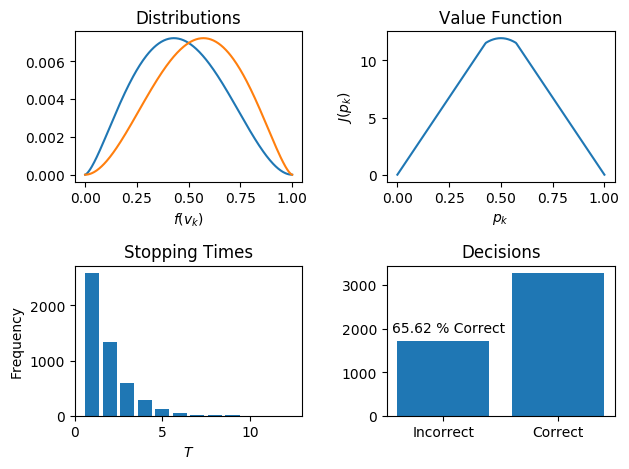

In [17]:
fig, allax = subplots(2, 2)

ax1, ax2 = allax[1, 1], allax[1, 2]
ax3, ax4 = allax[2, 1], allax[2, 2]

ax1[:plot](wf.pgrid, wf.f0, label=L"$f_0$")
ax1[:plot](wf.pgrid, wf.f1, label=L"$f_1$")
ax1[:set_title]("Distributions")
ax1[:set_xlabel](L"$v_k$")
ax1[:set_xlabel](L"$f(v_k)$")

ax2[:plot](wf.pgrid, wf.sol.J)
ax2[:set_title]("Value Function")
ax2[:set_xlabel](L"$p_k$")
ax2[:set_ylabel](L"$J(p_k)$")

count_stop_time = Array{Int64}(maximum(tdist))
for i in 1:maximum(tdist)
    count_stop_time[i] = sum(tdist .== i)
end
ax3[:bar](collect(1:maximum(tdist)), count_stop_time)
ax3[:set_title]("Stopping Times")
ax3[:set_xlabel](L"$T$")
ax3[:set_ylabel]("Frequency")

ncorrect = sum(cdist)
nincorrect = length(cdist) - ncorrect
ax4[:bar]([0, 1], [nincorrect, ncorrect])
ax4[:annotate]("$(100*mean(cdist)) \% Correct", [-0.45, nincorrect+200])
ax4[:set_title]("Decisions")
ax4[:set_xticks]([0.0, 1.0])
ax4[:set_xticklabels](["Incorrect", "Correct"])

fig[:tight_layout]()